In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot as gpp
import xgboost as xgb
gpp.set_aesthetics(context = 'paper')

In [55]:
#read in tiling data
crispri_tiling = pd.read_csv('../../Data/cleanedData/CombinedCleanedDatasets.csv')

crispri_tiling['cell_line'] = crispri_tiling['condition']

#average z-scores across different screens for each guide
crispri_tiling = crispri_tiling.groupby(['Target Gene Symbol',
                                         'sgRNA Context Sequence',
                                         'sgRNA \'Cut\' Position',
                                         'sgRNA \'Cut\' Site TSS Offset',
                                         'TSS Position',
                                         'Strand of Target',
                                         'cell_line',
                                         'rs3ChenSeqScore'])['signed_zscore'].mean().reset_index()

crispri_tiling

,Target Gene Symbol,sgRNA Context Sequence,sgRNA 'Cut' Position,sgRNA 'Cut' Site TSS Offset,TSS Position,Strand of Target,cell_line,rs3ChenSeqScore,signed_zscore
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,HCT116,0.517537,4.222014
2,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,36949430.0,475.0,36948955.0,+,A549,0.011229,1.423142
3,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,36949430.0,475.0,36948955.0,+,HCT116,0.011229,5.034713
4,AATF,AAAGAAGCCGAAGCCCTCCTCCCGAGGCCG,36949375.0,420.0,36948955.0,+,A549,0.316988,4.960397
...,...,...,...,...,...,...,...,...,...
171704,ZNHIT6,TTTAATGGTTAACACAGATTAGGGTGGGTT,85708727.0,-293.0,85708433.0,-,K562,0.611774,0.324543
171705,ZNHIT6,TTTACGGCTCTGCGGAGGCCCTGCCGGATT,85708514.0,-80.0,85708433.0,-,K562,-0.431003,0.245263
171706,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,85707893.0,541.0,85708433.0,-,K562,0.557163,0.605250
171707,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249


In [127]:
#read in gencode48 transcripts
all_gencode_48_transcripts = pd.read_csv('../../Data/GENCODE48/gencode_48_protein_coding_transcripts.csv')
all_gencode_48_transcripts['MANE Select'] = all_gencode_48_transcripts['tag'].str.contains('MANE_Select') == True
all_gencode_48_transcripts = all_gencode_48_transcripts[['gene_name','TSS','MANE Select']].drop_duplicates()
all_gencode_48_transcripts

,gene_name,TSS,MANE Select
0,OR4F5,65419,True
1,OR4F29,451678,True
2,OR4F16,686654,True
3,SAMD11,923923,True
4,SAMD11,923923,False
...,...,...,...
171904,ENSG00000278633,13001,False
171905,ENSG00000276017,72411,False
171906,ENSG00000278817,131494,False
171907,ENSG00000277196,161750,False


In [128]:
#merge on gene symbol
tiling_transcripts_merged = crispri_tiling.merge(all_gencode_48_transcripts,
                                                 left_on = 'Target Gene Symbol',
                                                 right_on = 'gene_name',
                                                 how = 'inner')
tiling_transcripts_merged

,Target Gene Symbol,sgRNA Context Sequence,sgRNA 'Cut' Position,sgRNA 'Cut' Site TSS Offset,TSS Position,Strand of Target,cell_line,rs3ChenSeqScore,signed_zscore,gene_name,TSS,MANE Select
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948925,False
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948954,True
2,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948967,False
3,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36949008,False
4,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36949019,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1944708,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,85707893.0,541.0,85708433.0,-,K562,0.557163,0.605250,ZNHIT6,85708433,False
1944709,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,85708433,True
1944710,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,85708433,False
1944711,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,85708387.0,47.0,85708433.0,-,K562,-0.326489,-0.340156,ZNHIT6,85708433,True


In [129]:
#make a separate column denoting MANE TSS of each gene
mane_tsss = tiling_transcripts_merged[tiling_transcripts_merged['MANE Select']][['Target Gene Symbol','TSS']].drop_duplicates()
mane_tsss = mane_tsss.rename(columns = {'TSS':'MANE TSS'})
tiling_transcripts_merged = tiling_transcripts_merged.merge(mane_tsss)
tiling_transcripts_merged

,Target Gene Symbol,sgRNA Context Sequence,sgRNA 'Cut' Position,sgRNA 'Cut' Site TSS Offset,TSS Position,Strand of Target,cell_line,rs3ChenSeqScore,signed_zscore,gene_name,TSS,MANE Select,MANE TSS
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948925,False,36948954
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948954,True,36948954
2,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948967,False,36948954
3,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36949008,False,36948954
4,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36949019,False,36948954
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944708,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,85707893.0,541.0,85708433.0,-,K562,0.557163,0.605250,ZNHIT6,85708433,False,85708433
1944709,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,85708433,True,85708433
1944710,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,85708433,False,85708433
1944711,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,85708387.0,47.0,85708433.0,-,K562,-0.326489,-0.340156,ZNHIT6,85708433,True,85708433


<Axes: xlabel='tss_offset', ylabel='signed_zscore'>

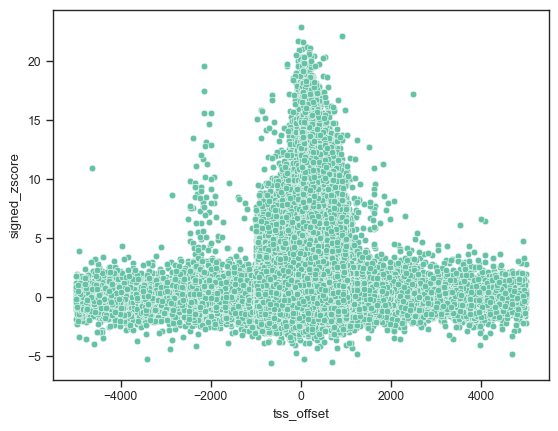

In [130]:
#calculate tss offset
tiling_transcripts_merged['tss_offset'] = np.where(tiling_transcripts_merged['Strand of Target'] == '+',
                                                   tiling_transcripts_merged['sgRNA \'Cut\' Position'] - tiling_transcripts_merged['TSS'],
                                                   tiling_transcripts_merged['TSS'] - tiling_transcripts_merged['sgRNA \'Cut\' Position'])

#plot tss offset vs z-score as a sanity check
plot_df = tiling_transcripts_merged[(tiling_transcripts_merged['MANE Select'])]
sns.scatterplot(data = plot_df, x = 'tss_offset', y = 'signed_zscore')

### Calculate RS3i scores to pick top N guides per gene

In [131]:
#obtain ATAC peak overlap scores
trainData = pd.read_csv('../../Data/modelTraining/trainData_rs3i.csv')
testData = pd.read_csv('../../Data/modelTraining/testData_rs3i.csv')
all_featurized_data = pd.concat([trainData,testData]).reset_index(drop=True)
atac_overlap_scores = all_featurized_data[['Target_Gene_Symbol',
                                           'sgRNA_Context_Sequence',
                                           'ATAC_overlap_with_peak__0.0__0.5_',
                                           'ATAC_overlap_with_peak__0.5__1.0_',
                                           'ATAC_overlap_with_peak__1.0__inf_']].drop_duplicates()
atac_overlap_scores

,Target_Gene_Symbol,sgRNA_Context_Sequence,ATAC_overlap_with_peak__0.0__0.5_,ATAC_overlap_with_peak__0.5__1.0_,ATAC_overlap_with_peak__1.0__inf_
0,AATF,GTTTAGAGGGGTCTAGGTCTCTACAGGCAA,1,0,0
1,AATF,GTCTATTCTTATGGTATCTGTTGGAGGTTG,1,0,0
2,AATF,GTGGTCTATTCTTATGGTATCTGTTGGAGG,1,0,0
3,AATF,TGACTACAAAGTGGTCTATTCTTATGGTAT,1,0,0
4,AATF,GGGATGATAAGTGTGACTACAAAGTGGTCT,1,0,0
...,...,...,...,...,...
121425,ZNHIT6,GGAGTCAGACGGCGTTCGCGGGGGTGGGTT,1,0,0
121426,ZNHIT6,GAGTCAGACGGCGTTCGCGGGGGTGGGTTG,1,0,0
121427,ZNHIT6,ATACATGAAATTAGTAGTGTCCAATGGGTA,1,0,0
121428,ZNHIT6,TACATGAAATTAGTAGTGTCCAATGGGTAA,1,0,0


In [132]:
#merge
tiling_transcripts_merged_scored = tiling_transcripts_merged.merge(atac_overlap_scores,
                                                                    left_on = ['Target Gene Symbol','sgRNA Context Sequence'],
                                                                    right_on = ['Target_Gene_Symbol','sgRNA_Context_Sequence'],
                                                                    how = 'inner')
rs3i_input = tiling_transcripts_merged_scored[['tss_offset',
                                             'rs3ChenSeqScore',
                                             'ATAC_overlap_with_peak__0.0__0.5_',
                                             'ATAC_overlap_with_peak__0.5__1.0_',
                                             'ATAC_overlap_with_peak__1.0__inf_']]
rs3i_input = rs3i_input.rename(columns = {'tss_offset':'sgRNA_\'Cut\'_Site_TSS_Offset'})
rs3i_input

,sgRNA_'Cut'_Site_TSS_Offset,rs3ChenSeqScore,ATAC_overlap_with_peak__0.0__0.5_,ATAC_overlap_with_peak__0.5__1.0_,ATAC_overlap_with_peak__1.0__inf_
0,711.0,0.517537,1,0,0
1,682.0,0.517537,1,0,0
2,669.0,0.517537,1,0,0
3,628.0,0.517537,1,0,0
4,617.0,0.517537,1,0,0
...,...,...,...,...,...
1931521,540.0,0.557163,0,1,0
1931522,942.0,-0.492183,1,0,0
1931523,942.0,-0.492183,1,0,0
1931524,46.0,-0.326489,0,0,1


In [133]:
#import model and calculate rs3i scores
rs3i = xgb.XGBRegressor()
rs3i.load_model('../../Data/modelTraining/RS3i.json')
tiling_transcripts_merged_scored['RS3i'] = rs3i.predict(rs3i_input)
tiling_transcripts_merged_scored

,Target Gene Symbol,sgRNA Context Sequence,sgRNA 'Cut' Position,sgRNA 'Cut' Site TSS Offset,TSS Position,Strand of Target,cell_line,rs3ChenSeqScore,signed_zscore,gene_name,TSS,MANE Select,MANE TSS,tss_offset,Target_Gene_Symbol,sgRNA_Context_Sequence,ATAC_overlap_with_peak__0.0__0.5_,ATAC_overlap_with_peak__0.5__1.0_,ATAC_overlap_with_peak__1.0__inf_,RS3i
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948925,False,36948954,711.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.000794
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948954,True,36948954,682.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.028408
2,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36948967,False,36948954,669.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.028408
3,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36949008,False,36948954,628.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.069805
4,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,36949019,False,36948954,617.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.069805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931521,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,85707893.0,541.0,85708433.0,-,K562,0.557163,0.605250,ZNHIT6,85708433,False,85708433,540.0,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,0,1,0,0.298475
1931522,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,85708433,True,85708433,942.0,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,1,0,0,-0.414706
1931523,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,85708433,False,85708433,942.0,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,1,0,0,-0.414706
1931524,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,85708387.0,47.0,85708433.0,-,K562,-0.326489,-0.340156,ZNHIT6,85708433,True,85708433,46.0,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,0,0,1,1.265180


In [134]:
def count_overlapping_matches(seq,pattern):
    count = 0
    length = len(pattern)
    for i in range(len(seq)-1):
        if seq[i:(i+length)] == pattern:
            count +=1
    return count

In [135]:
#calculate number of GGs within seed sequence of each guide
tiling_transcripts_merged_scored['seed_seq'] = tiling_transcripts_merged_scored['sgRNA Context Sequence'].str[4:24].str[-12:]
tiling_transcripts_merged_scored['Seed Score'] = tiling_transcripts_merged_scored['seed_seq'].apply(lambda seq: count_overlapping_matches(seq,'GG'))
tiling_transcripts_merged_scored                                                                                    

,Target Gene Symbol,sgRNA Context Sequence,sgRNA 'Cut' Position,sgRNA 'Cut' Site TSS Offset,TSS Position,Strand of Target,cell_line,rs3ChenSeqScore,signed_zscore,gene_name,...,MANE TSS,tss_offset,Target_Gene_Symbol,sgRNA_Context_Sequence,ATAC_overlap_with_peak__0.0__0.5_,ATAC_overlap_with_peak__0.5__1.0_,ATAC_overlap_with_peak__1.0__inf_,RS3i,seed_seq,Seed Score
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,711.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.000794,GAGACTGATGGA,1
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,682.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.028408,GAGACTGATGGA,1
2,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,669.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.028408,GAGACTGATGGA,1
3,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,628.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.069805,GAGACTGATGGA,1
4,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,617.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.069805,GAGACTGATGGA,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931521,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,85707893.0,541.0,85708433.0,-,K562,0.557163,0.605250,ZNHIT6,...,85708433,540.0,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,0,1,0,0.298475,AGAAGCGAAGGT,1
1931522,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,...,85708433,942.0,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,1,0,0,-0.414706,GACGGCGTTCGC,1
1931523,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,...,85708433,942.0,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,1,0,0,-0.414706,GACGGCGTTCGC,1
1931524,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,85708387.0,47.0,85708433.0,-,K562,-0.326489,-0.340156,ZNHIT6,...,85708433,46.0,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,0,0,1,1.265180,TGGCTCCACACG,1


In [148]:
#subset to predicted nonpromiscuous guides
tiling_transcripts_merged_nonpromiscuous = tiling_transcripts_merged_scored[tiling_transcripts_merged_scored['Seed Score'] < 3].copy()
tiling_transcripts_merged_nonpromiscuous

,Target Gene Symbol,sgRNA Context Sequence,sgRNA 'Cut' Position,sgRNA 'Cut' Site TSS Offset,TSS Position,Strand of Target,cell_line,rs3ChenSeqScore,signed_zscore,gene_name,...,MANE TSS,tss_offset,Target_Gene_Symbol,sgRNA_Context_Sequence,ATAC_overlap_with_peak__0.0__0.5_,ATAC_overlap_with_peak__0.5__1.0_,ATAC_overlap_with_peak__1.0__inf_,RS3i,seed_seq,Seed Score
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,711.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.000794,GAGACTGATGGA,1
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,682.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.028408,GAGACTGATGGA,1
2,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,669.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.028408,GAGACTGATGGA,1
3,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,628.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.069805,GAGACTGATGGA,1
4,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,36948954,617.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.069805,GAGACTGATGGA,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931521,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,85707893.0,541.0,85708433.0,-,K562,0.557163,0.605250,ZNHIT6,...,85708433,540.0,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,0,1,0,0.298475,AGAAGCGAAGGT,1
1931522,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,...,85708433,942.0,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,1,0,0,-0.414706,GACGGCGTTCGC,1
1931523,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,...,85708433,942.0,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,1,0,0,-0.414706,GACGGCGTTCGC,1
1931524,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,85708387.0,47.0,85708433.0,-,K562,-0.326489,-0.340156,ZNHIT6,...,85708433,46.0,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,0,0,1,1.265180,TGGCTCCACACG,1


In [150]:
#rank guides per TSS in terms of RS3i score
tiling_transcripts_merged_nonpromiscuous['on_target_rank'] = tiling_transcripts_merged_nonpromiscuous.groupby(['Target Gene Symbol','cell_line','TSS','MANE Select'])['RS3i'].transform('rank',ascending=False,method='first')
tiling_transcripts_merged_nonpromiscuous

,Target Gene Symbol,sgRNA Context Sequence,sgRNA 'Cut' Position,sgRNA 'Cut' Site TSS Offset,TSS Position,Strand of Target,cell_line,rs3ChenSeqScore,signed_zscore,gene_name,...,tss_offset,Target_Gene_Symbol,sgRNA_Context_Sequence,ATAC_overlap_with_peak__0.0__0.5_,ATAC_overlap_with_peak__0.5__1.0_,ATAC_overlap_with_peak__1.0__inf_,RS3i,seed_seq,Seed Score,on_target_rank
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,711.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.000794,GAGACTGATGGA,1,106.0
1,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,682.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.028408,GAGACTGATGGA,1,100.0
2,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,669.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.028408,GAGACTGATGGA,1,97.0
3,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,628.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.069805,GAGACTGATGGA,1,88.0
4,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,36949636.0,681.0,36948955.0,+,A549,0.517537,-0.877642,AATF,...,617.0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,1,0,0,0.069805,GAGACTGATGGA,1,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931521,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,85707893.0,541.0,85708433.0,-,K562,0.557163,0.605250,ZNHIT6,...,540.0,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,0,1,0,0.298475,AGAAGCGAAGGT,1,50.0
1931522,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,...,942.0,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,1,0,0,-0.414706,GACGGCGTTCGC,1,140.0
1931523,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,85707491.0,943.0,85708433.0,-,K562,-0.492183,0.953249,ZNHIT6,...,942.0,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,1,0,0,-0.414706,GACGGCGTTCGC,1,140.0
1931524,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,85708387.0,47.0,85708433.0,-,K562,-0.326489,-0.340156,ZNHIT6,...,46.0,ZNHIT6,TTTGTGGCTGCTTGGCTCCACACGTGGGCC,0,0,1,1.265180,TGGCTCCACACG,1,13.0


In [163]:
#subset to best three guides per TSS
top3_guides = tiling_transcripts_merged_nonpromiscuous[tiling_transcripts_merged_nonpromiscuous['on_target_rank'] <= 3].copy()
top3_guides.groupby(['Target Gene Symbol','TSS','cell_line','MANE Select'])['sgRNA Context Sequence'].nunique().value_counts()

3    6980
Name: sgRNA Context Sequence, dtype: int64

In [176]:
#calculate average z-score per TSS
average_zscore_df = top3_guides.groupby(['Target Gene Symbol',
                                         'cell_line','TSS',
                                         'MANE TSS','MANE Select']).agg(average_zscore = ('signed_zscore','mean'),
                                                                        num_guides = ('sgRNA Context Sequence','nunique')).reset_index()
average_zscore_df

,Target Gene Symbol,cell_line,TSS,MANE TSS,MANE Select,average_zscore,num_guides
0,AATF,A549,36948925,36948954,False,3.694465,3
1,AATF,A549,36948954,36948954,True,6.095492,3
2,AATF,A549,36948967,36948954,False,4.425523,3
3,AATF,A549,36949008,36948954,False,2.673619,3
4,AATF,A549,36949019,36948954,False,2.673619,3
...,...,...,...,...,...,...,...
6975,ZNF574,K562,42076166,42076166,True,9.347204,3
6976,ZNF830,K562,34961540,34961540,True,4.810346,3
6977,ZNF830,K562,34962365,34961540,False,0.257176,3
6978,ZNHIT6,K562,85708433,85708433,False,13.326422,3


In [177]:
#subset to alternative TSSs that are sufficiently far from the MANE TSS
average_zscore_df['dist_from_MANE'] = np.abs(average_zscore_df['MANE TSS'] - average_zscore_df['TSS'])
average_zscore_df = average_zscore_df[(average_zscore_df['dist_from_MANE'] > 25) | average_zscore_df['MANE Select']]
average_zscore_df

,Target Gene Symbol,cell_line,TSS,MANE TSS,MANE Select,average_zscore,num_guides,dist_from_MANE
0,AATF,A549,36948925,36948954,False,3.694465,3,29
1,AATF,A549,36948954,36948954,True,6.095492,3,0
3,AATF,A549,36949008,36948954,False,2.673619,3,54
4,AATF,A549,36949019,36948954,False,2.673619,3,65
5,AATF,A549,36949285,36948954,False,3.033662,3,331
...,...,...,...,...,...,...,...,...
6974,ZNF574,K562,42074671,42076166,False,3.380165,3,1495
6975,ZNF574,K562,42076166,42076166,True,9.347204,3,0
6976,ZNF830,K562,34961540,34961540,True,4.810346,3,0
6977,ZNF830,K562,34962365,34961540,False,0.257176,3,825


<Axes: >

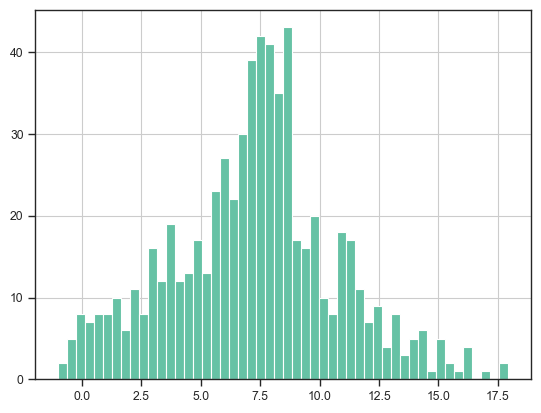

In [178]:
#choosing a cutoff for a tss which "worked" and a tss which didn't
average_zscore_df[average_zscore_df['MANE Select']]['average_zscore'].hist(bins=50)

<Axes: >

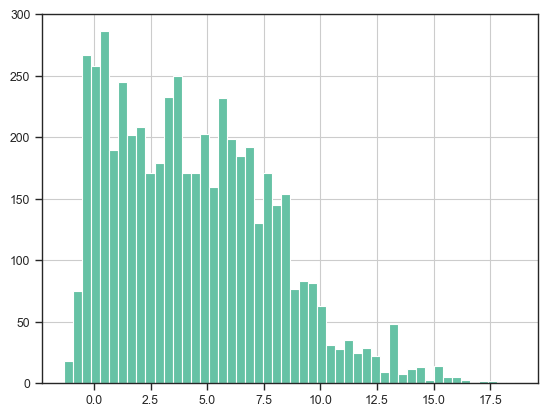

In [179]:
average_zscore_df['average_zscore'].hist(bins=50)

<Axes: >

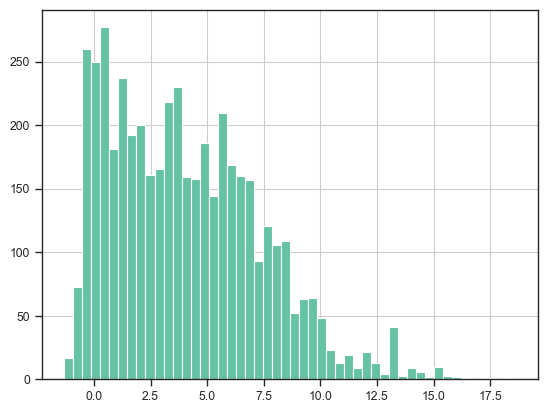

In [180]:
average_zscore_df[~average_zscore_df['MANE Select']]['average_zscore'].hist(bins=50)

In [199]:
average_zscore_df['worked'] = average_zscore_df['average_zscore'] > 3
average_zscore_df['failed'] = average_zscore_df['average_zscore'] < 1

/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_93514/3797345298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  average_zscore_df['worked'] = average_zscore_df['average_zscore'] > 3
/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_93514/3797345298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  average_zscore_df['failed'] = average_zscore_df['average_zscore'] < 1


In [200]:
#remove ambiguous cases
tss_success_df = average_zscore_df[average_zscore_df['worked'] | average_zscore_df['failed']].copy()

#remove genes for which no tss worked
tss_success_df['at_least_one_tss_worked'] = tss_success_df.groupby(['Target Gene Symbol','cell_line'])['worked'].transform('any')
tss_success_df = tss_success_df[tss_success_df['at_least_one_tss_worked']]

#now subset to just mane tsss
mane_success_df = tss_success_df[tss_success_df['MANE Select']].copy()

#calculate fnr per cell line (false negative = mane select failed and another tss worked)
fnr_df = mane_success_df.groupby('cell_line').agg(false_negative_rate = ('failed','mean'),
                                                  num_genes = ('Target Gene Symbol','nunique')).reset_index()
fnr_df

,cell_line,false_negative_rate,num_genes
0,A549,0.017241,116
1,HCT116,0.024390,123
2,K562,0.008850,339


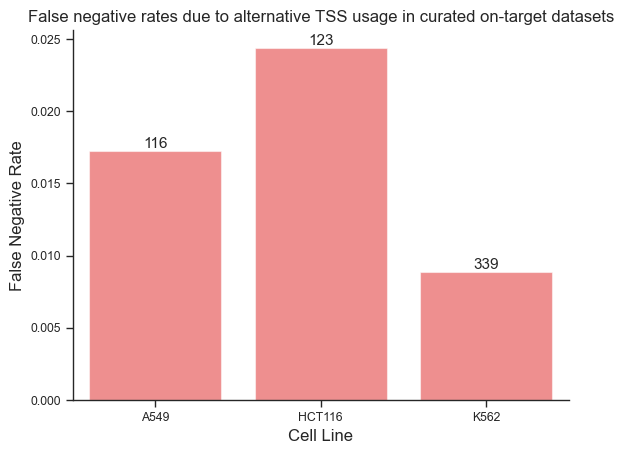

In [203]:
sns.barplot(data = fnr_df, x = 'cell_line', y = 'false_negative_rate', color = 'Red', alpha=0.5)
plt.xlabel('Cell Line',fontsize=12)
plt.ylabel('False Negative Rate',fontsize=12)
plt.title('False negative rates due to alternative TSS usage in curated on-target datasets',fontsize=12)
sns.despine()

#annotate with number of genes
for x,cell_line in enumerate(fnr_df.cell_line):
    n = fnr_df.loc[fnr_df['cell_line'] == cell_line,'num_genes'].tolist()[0]
    fnr = fnr_df.loc[fnr_df['cell_line'] == cell_line,'false_negative_rate'].tolist()[0]
    plt.text(x,fnr+0.0002,str(n),ha='center',fontsize=11)

gpp.savefig("../../Figures/Figure 6/fnr_alt_tss_usage_barplot.pdf", dpi=300, bbox_inches='tight')